# Classification Dog/Cat With CNN

## Import

In [24]:
import torch
import torch.nn as nn

from torchvision import datasets 
from torchvision import transforms as T
from torchvision.io import read_image
from torchmetrics import Accuracy
import torch.optim as optim
from torch.utils.data import DataLoader , Dataset , random_split

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm

## Data

In [2]:
train_tranform = T.Compose([T.RandomHorizontalFlip(),
                             T.Resize((128, 128)),
                             T.RandomCrop(128 , 8),
                             T.ToTensor(),
                             T.Normalize(mean=[0.5 , 0.5 , 0.5],
                                         std=[0.5 , 0.5 , 0.5])])
test_transform = T.Compose([T.Resize((128, 128)),
                             T.ToTensor(),
                             T.Normalize(mean=[0.5 , 0.5 , 0.5],
                                         std=[0.5 , 0.5 , 0.5])])

In [3]:
train_set = datasets.ImageFolder('dataset/training_set' , transform=train_tranform)
test_set = datasets.ImageFolder('dataset/test_set' , transform=test_transform)

In [4]:
train_dataloader = DataLoader(train_set ,  batch_size= 64 , shuffle=True) 

test_dataloader = DataLoader(test_set , batch_size= 32)

In [5]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)
    
    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

## Visualize

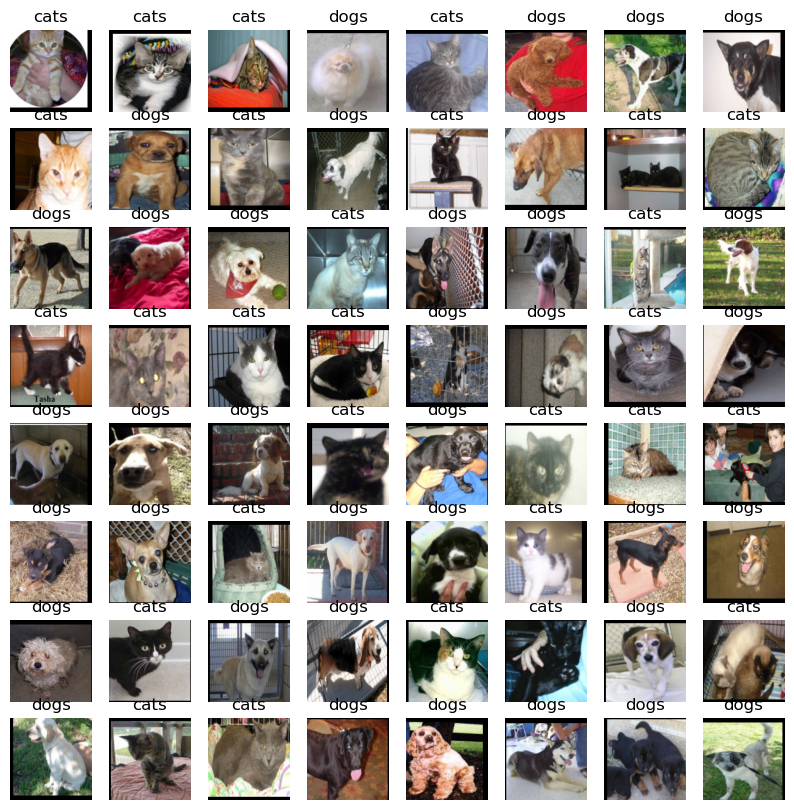

In [6]:
batch = next(iter(train_dataloader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

## Functions

In [7]:
def conv3x3_bn_af(in_channels , out_channels):
    module = nn.Sequential(nn.Conv2d(in_channels=in_channels , out_channels=out_channels ,  kernel_size=3, padding=1),
                           nn.BatchNorm2d(out_channels),
                           nn.ReLU())
    return module

In [8]:
def CNN():
    network = nn.Sequential(conv3x3_bn_af(3 , 32), #32x32
                            conv3x3_bn_af(32 , 32),
                            nn.MaxPool2d(2 , 2), 

                            conv3x3_bn_af(32 , 64), #32x32
                            conv3x3_bn_af(64 , 64),
                            nn.MaxPool2d(2 , 2), #16x16

                            conv3x3_bn_af(64 , 128),
                            conv3x3_bn_af(128 , 128),
                            nn.MaxPool2d(2 , 2), #8x8

                            conv3x3_bn_af(128,256),
                            conv3x3_bn_af(256,256),
                            nn.MaxPool2d(2 , 2), #4x4

                            conv3x3_bn_af(256 , 512),
                            conv3x3_bn_af(512 , 512),
                            nn.AdaptiveAvgPool2d(output_size=(1 , 1)), #1x1

                            nn.Flatten(),
                            nn.Linear(512 , 2)
                        )                   
    return network

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
def train_one_epoch(model, train_dataloader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task="multiclass", num_classes=2).to(device)
  with tqdm(train_dataloader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg, 
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [12]:
def validation(model, test_dataloader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task="multiclass", num_classes=2).to(device)
    for i, (inputs, targets) in enumerate(test_dataloader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      
      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

## Efficient Way For Set Hyperparams

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Check Forward Path

In [15]:
x_batch, y_batch = next(iter(train_dataloader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(0.7358, device='cuda:0', grad_fn=<NllLossBackward0>)


### Check Backward Path

In [16]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-1000, 1000))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [17]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 50/50 [00:05<00:00,  8.60batch/s, accuracy=79.2, loss=0.426]


### Select Best Learning Rate

In [18]:
num_epochs = 2
for lr in [0.1, 0.01 , 0.001]:
  print(f'LR={lr}')
  model = CNN().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_dataloader, loss_fn, optimizer, epoch)
  print()

LR=0.1


Epoch 1: 100%|██████████| 125/125 [00:36<00:00,  3.38batch/s, accuracy=69.3, loss=0.585]



LR=0.01


Epoch 1: 100%|██████████| 125/125 [00:37<00:00,  3.30batch/s, accuracy=70.8, loss=0.564]



LR=0.001


Epoch 1: 100%|██████████| 125/125 [00:36<00:00,  3.41batch/s, accuracy=64.1, loss=0.632]

### Small Grid

In [19]:
num_epochs = 5
for lr in [0.008 , 0.01 , 0.015 , 0.02 , 0.05]:
  for wd in [0 , 1e-4 , 1e-5]:
    print(f'LR={lr} WD={wd}')
    model = CNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    for epoch in range(num_epochs):
        model, _, _ = train_one_epoch(model, train_dataloader, loss_fn, optimizer, epoch)
    print()

LR=0.008 WD=0


Epoch 4: 100%|██████████| 125/125 [00:36<00:00,  3.40batch/s, accuracy=78.2, loss=0.455]



LR=0.008 WD=0.0001


Epoch 4: 100%|██████████| 125/125 [00:36<00:00,  3.38batch/s, accuracy=77.9, loss=0.463]



LR=0.008 WD=1e-05


Epoch 4: 100%|██████████| 125/125 [00:36<00:00,  3.38batch/s, accuracy=79.1, loss=0.453]



LR=0.01 WD=0


Epoch 4: 100%|██████████| 125/125 [00:37<00:00,  3.33batch/s, accuracy=79.1, loss=0.443]



LR=0.01 WD=0.0001


Epoch 4: 100%|██████████| 125/125 [00:37<00:00,  3.37batch/s, accuracy=79.3, loss=0.44] 



LR=0.01 WD=1e-05


Epoch 4: 100%|██████████| 125/125 [00:40<00:00,  3.12batch/s, accuracy=78.7, loss=0.45] 



LR=0.015 WD=0


Epoch 4: 100%|██████████| 125/125 [00:37<00:00,  3.34batch/s, accuracy=81.9, loss=0.398]



LR=0.015 WD=0.0001


Epoch 4: 100%|██████████| 125/125 [00:37<00:00,  3.32batch/s, accuracy=81.2, loss=0.413]



LR=0.015 WD=1e-05


Epoch 4: 100%|██████████| 125/125 [00:36<00:00,  3.42batch/s, accuracy=80.1, loss=0.432]



LR=0.02 WD=0


Epoch 4: 100%|██████████| 125/125 [00:36<00:00,  3.39batch/s, accuracy=82.1, loss=0.404]



LR=0.02 WD=0.0001


Epoch 4: 100%|██████████| 125/125 [00:37<00:00,  3.29batch/s, accuracy=82.7, loss=0.38] 



LR=0.02 WD=1e-05


Epoch 4: 100%|██████████| 125/125 [00:37<00:00,  3.32batch/s, accuracy=81.8, loss=0.399]



LR=0.05 WD=0


Epoch 4: 100%|██████████| 125/125 [00:37<00:00,  3.38batch/s, accuracy=85.1, loss=0.34] 



LR=0.05 WD=0.0001


Epoch 4: 100%|██████████| 125/125 [00:37<00:00,  3.36batch/s, accuracy=84.2, loss=0.36] 



LR=0.05 WD=1e-05


Epoch 4: 100%|██████████| 125/125 [00:37<00:00,  3.30batch/s, accuracy=84.8, loss=0.339]

## Train Model

In [13]:
model = CNN().to(device)

In [14]:
lr = 0.05
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

In [15]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [18]:
num_epochs = 15

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, 
                                                 train_dataloader, 
                                                 loss_fn, 
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_dataloader,
                                     loss_fn)
  
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)
  
  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 125/125 [01:39<00:00,  1.26batch/s, accuracy=65.2, loss=0.62] 


Valid: Loss = 0.6451, Acc = 0.6315



Epoch 1: 100%|██████████| 125/125 [00:39<00:00,  3.16batch/s, accuracy=71.4, loss=0.559]


Valid: Loss = 0.7144, Acc = 0.581



Epoch 2: 100%|██████████| 125/125 [00:38<00:00,  3.28batch/s, accuracy=74.7, loss=0.517]


Valid: Loss = 0.5254, Acc = 0.7425



Epoch 3: 100%|██████████| 125/125 [00:38<00:00,  3.26batch/s, accuracy=77, loss=0.476]  


Valid: Loss = 0.4898, Acc = 0.764



Epoch 4: 100%|██████████| 125/125 [00:38<00:00,  3.29batch/s, accuracy=79.4, loss=0.439]


Valid: Loss = 0.4386, Acc = 0.802



Epoch 5: 100%|██████████| 125/125 [00:38<00:00,  3.26batch/s, accuracy=81, loss=0.413]  


Valid: Loss = 0.417, Acc = 0.8165



Epoch 6: 100%|██████████| 125/125 [00:38<00:00,  3.25batch/s, accuracy=82.8, loss=0.378]


Valid: Loss = 0.3881, Acc = 0.8345



Epoch 7: 100%|██████████| 125/125 [01:33<00:00,  1.34batch/s, accuracy=84.5, loss=0.356]


Valid: Loss = 0.4937, Acc = 0.7995



Epoch 8: 100%|██████████| 125/125 [00:38<00:00,  3.21batch/s, accuracy=85.4, loss=0.333]


Valid: Loss = 0.5283, Acc = 0.7605



Epoch 9: 100%|██████████| 125/125 [00:38<00:00,  3.26batch/s, accuracy=86.3, loss=0.31] 


Valid: Loss = 0.4151, Acc = 0.821



Epoch 10: 100%|██████████| 125/125 [00:38<00:00,  3.22batch/s, accuracy=87.6, loss=0.292]


Valid: Loss = 0.3028, Acc = 0.873



Epoch 11: 100%|██████████| 125/125 [00:38<00:00,  3.26batch/s, accuracy=88.5, loss=0.272]


Valid: Loss = 0.2703, Acc = 0.891



Epoch 12: 100%|██████████| 125/125 [00:38<00:00,  3.27batch/s, accuracy=89.6, loss=0.252]


Valid: Loss = 0.32, Acc = 0.8575



Epoch 13: 100%|██████████| 125/125 [00:37<00:00,  3.30batch/s, accuracy=90.5, loss=0.239]


Valid: Loss = 0.7494, Acc = 0.7375



Epoch 14: 100%|██████████| 125/125 [00:38<00:00,  3.29batch/s, accuracy=91, loss=0.215]  


Valid: Loss = 0.3673, Acc = 0.8455



## Visualize

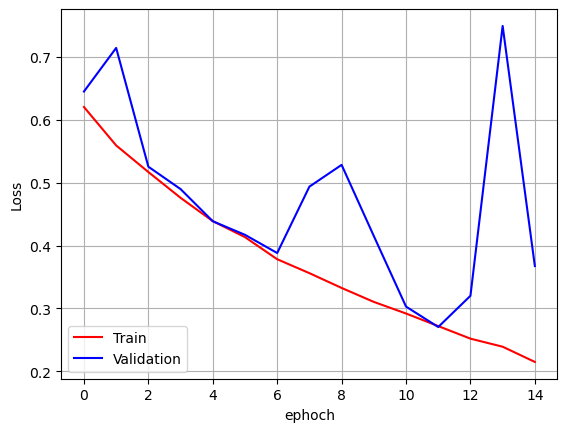

In [19]:
plt.plot(range(epoch_counter) , loss_train_hist , 'r-', label='Train')
plt.plot(range(epoch_counter) , loss_valid_hist , 'b-', label='Validation')

plt.xlabel("ephoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

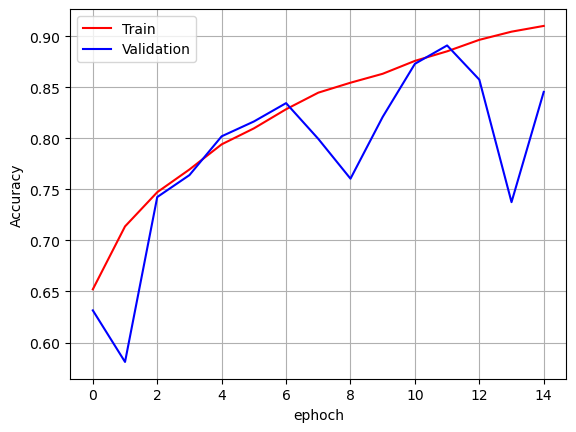

In [20]:
plt.plot(range(epoch_counter) , acc_train_hist , 'r-', label='Train')
plt.plot(range(epoch_counter) , acc_valid_hist , 'b-', label='Validation')

plt.xlabel("ephoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()


In [21]:
print(train_set.class_to_idx)

{'cats': 0, 'dogs': 1}


## Test Model (Single Prediction)

C:\Users\BEHRAD\AppData\Local\Temp\ipykernel_4228\3620499556.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model.pt")


Predicted: cats, prob_dog=0.4555


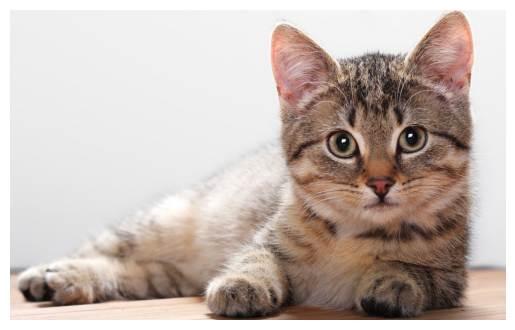

In [25]:
import torch
from torchvision.io import read_image
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = torch.load("model.pt")
model.to(device)
model.eval()


img_path = "dataset/single_prediction/cat_or_dog_2.jpg"


img = read_image(img_path).float() / 255.0  # scale [0,1]


img = img.unsqueeze(0)  # (1,C,H,W)
img = F.interpolate(img, size=(128,128), mode='bilinear', align_corners=False)

# Normalize
mean = torch.tensor([0.5,0.5,0.5], device=device).view(1,3,1,1)
std = torch.tensor([0.5,0.5,0.5], device=device).view(1,3,1,1)
img = (img.to(device) - mean) / std


with torch.no_grad():
    output = model(img)
    if output.shape[1] == 1:  
        prob_dog = torch.sigmoid(output)[0].item()
        pred_idx = 1 if prob_dog >= 0.5 else 0
    else:  
        probabilities = torch.softmax(output, dim=1)
        pred_idx = torch.argmax(probabilities, dim=1).item()
        prob_dog = probabilities[0,1].item()  


idx_to_class = {0: "cats", 1: "dogs"}
pred_class = idx_to_class[pred_idx]

print(f"Predicted: {pred_class}, prob_dog={prob_dog:.4f}")

img = Image.open(img_path)  # Open image
plt.imshow(img)
plt.axis('off')
plt.show()